In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn((n_samples, z_dim), device=device)

In [5]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2)
    )

In [6]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [7]:
def bce(pred, target):
  sigmoid = nn.Sigmoid()
  loss = -torch.mean(target * torch.log(sigmoid(pred)) + (1-target) * torch.log(sigmoid(1-pred)))
  return loss

In [8]:
def renyi(pred, disc_pred):
  '''
  pred - The discriminator's predictions of the generated images.
  disc_pred - The discriminator's predictions of the real images.
  '''
  sigmoid = nn.Sigmoid()
  ALPHA = 0.3
  multiplier = 1 / (ALPHA - 1)
  expected_value = torch.mean((1-sigmoid(pred)) ** (ALPHA - 1))
  expected_value_2 = torch.mean(sigmoid(disc_pred) ** (ALPHA - 1))
  loss = multiplier * torch.log(expected_value) + multiplier * torch.log(expected_value_2)
  return -loss

In [9]:
gen_criterion = renyi
disc_criterion = nn.BCEWithLogitsLoss()

In [10]:
# Set your parameters
#criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [11]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [12]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(num_images, z_dim, device=device)
    fake_images = gen(noise).detach()
    fake_predictions = disc(fake_images)
    real_predictions = disc(real)
    fake_loss = criterion(fake_predictions, torch.ones_like(fake_predictions))
    real_loss = criterion(real_predictions, torch.zeros_like(real_predictions))
    disc_loss = (fake_loss + real_loss) / 2
    return disc_loss

In [13]:
def get_gen_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(num_images, z_dim, device=device)
    fake_images = gen(noise)
    real_pred = disc(real)
    prediction = disc(fake_images)
    gen_loss = criterion(prediction, real_pred)
    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 2.4875702435970295, discriminator loss: 0.4065118682086466


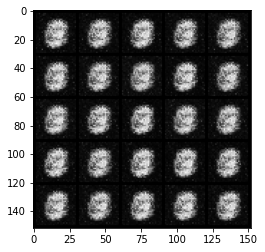

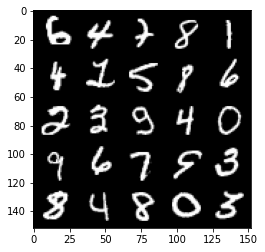

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 3.3324940648078947, discriminator loss: 0.24976129764318458


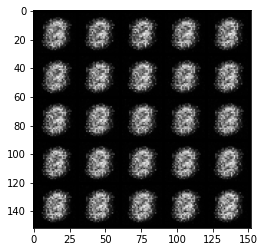

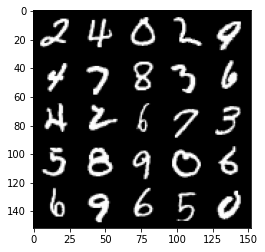

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 4.8231451406478865, discriminator loss: 0.1307869346290827


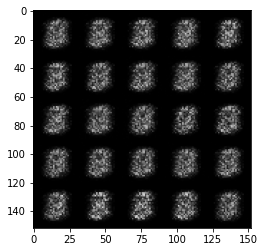

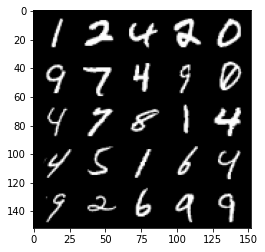

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 5.389355998992925, discriminator loss: 0.17270427690446372


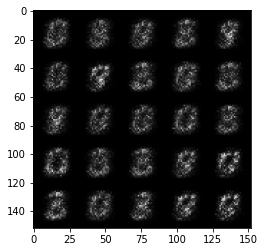

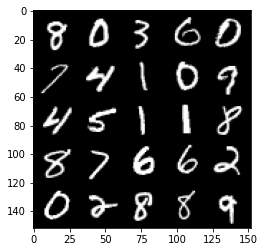

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 6.215670956611633, discriminator loss: 0.1758028064370155


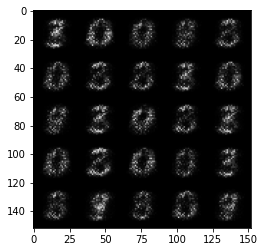

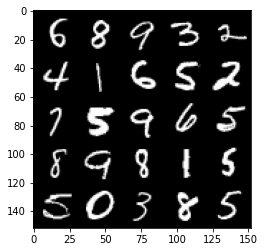

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 8.531416390419011, discriminator loss: 0.11809235255420206


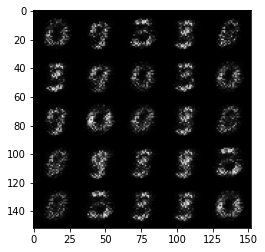

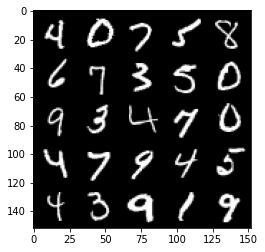

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 10.200875381469723, discriminator loss: 0.08983494666963822


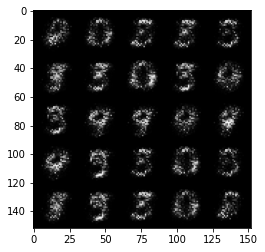

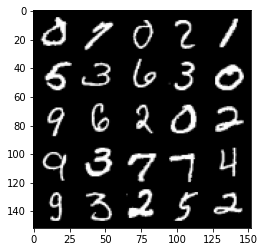

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 12.166928894042975, discriminator loss: 0.08755839265137909


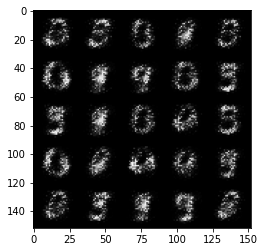

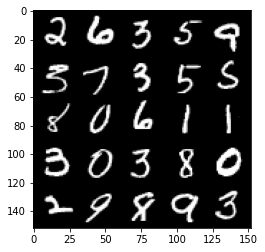

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 13.389468917846694, discriminator loss: 0.07905242105573407


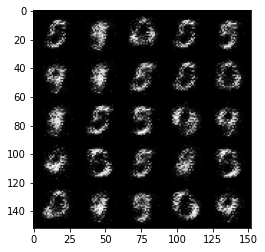

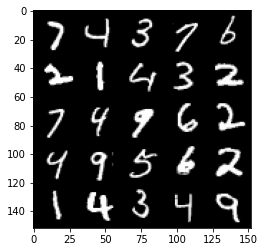

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 13.75738109588624, discriminator loss: 0.06386036199331284


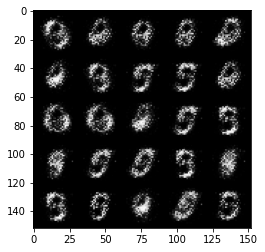

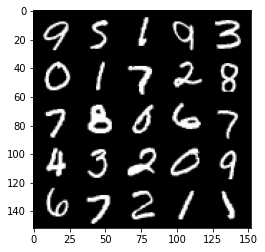

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 14.878490688323966, discriminator loss: 0.05283145667240025


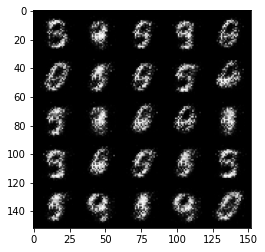

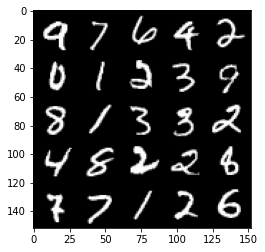

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 15.927521142959593, discriminator loss: 0.052819438859820336


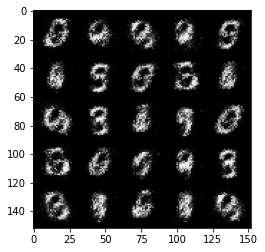

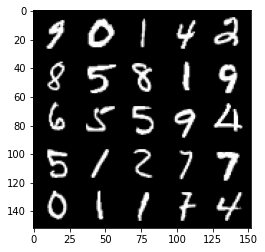

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 16.497187068939194, discriminator loss: 0.057181294728070486


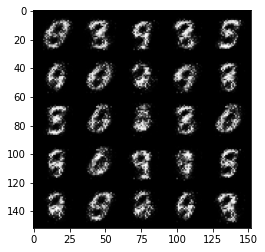

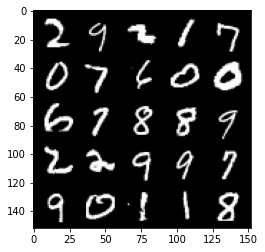

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 17.028293151855472, discriminator loss: 0.04989603464305404


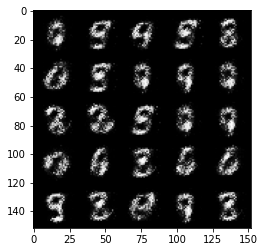

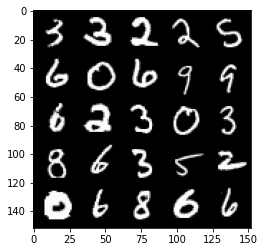

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 18.485243637084945, discriminator loss: 0.04138053988292811


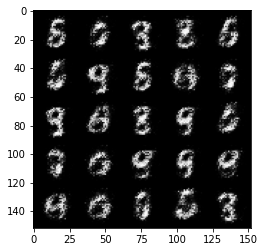

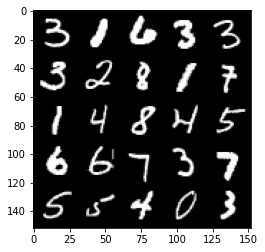

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 21.48760234451295, discriminator loss: 0.04292053355649111


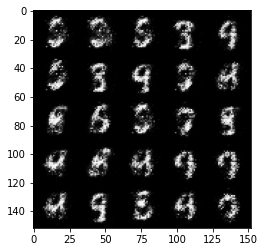

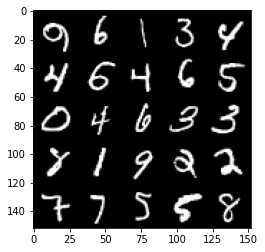

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 23.13899145889282, discriminator loss: 0.04656474693864581


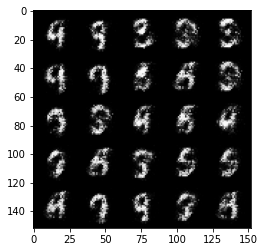

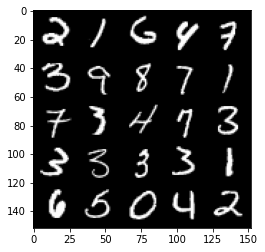

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 23.31447914123535, discriminator loss: 0.044895393557846566


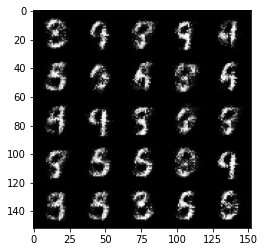

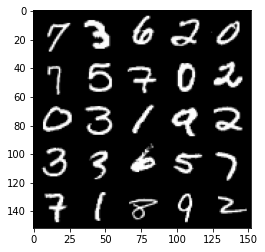

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 24.5207308998108, discriminator loss: 0.050215135168284186


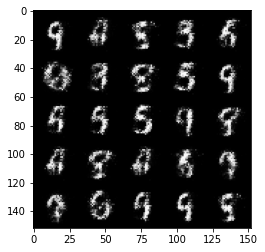

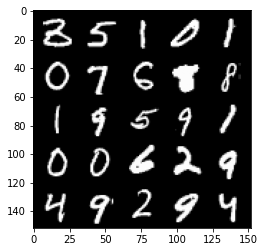

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 25.929124431610116, discriminator loss: 0.05146485885977752


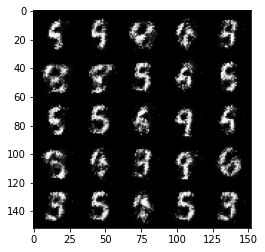

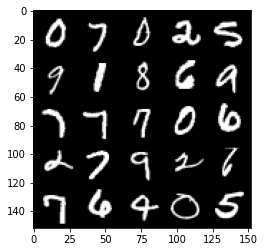

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 30.837344482421898, discriminator loss: 0.041071836629882424


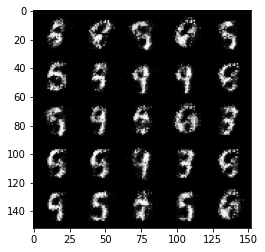

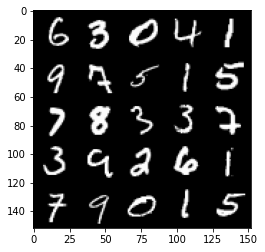

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [14]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, disc_criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, gen_criterion, real, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
